### 读不出的数据汇总：

#### 一期数据（健康）：共24个
- 第一次：收到21个，可使用19个。其中两个没有标注（剔除），一个为不平衡数据集（保留了）。
- 第二次：收到5个

#### 正常睡眠，补充：共23个
- 收到26个，可读出23个，3个读不来的原因是4th character of start date is not a valid 7-bit ASCII character.
- analysis: improve the sleep model
读不出来的数据如下：
1. Desktop/pylab/EEG数据集/正常睡眠，补充/35W-other/袁艳华之子_A区33N@20231026_231617
2. Desktop/pylab/EEG数据集/正常睡眠，补充/36W-other/张泽正_C区  46床@20231012_111224
3. Desktop/pylab/EEG数据集/正常睡眠，补充/40W-other/肖晓翠之女_D区45床@20230725_142208
   
#### 高胆换血病例EEG-：剔除低质量数据（通道只有9个和时长短），共26个
- 收到37个，可读出来的共36个。1个读不出来的原因是start date invalid.
- no events & annotations
- analysis: use the sleep model to predict on all data

读不出来的数据如下：
1. Desktop/pylab/EEG数据集/高胆换血病例EEG-/吴桂敏之子（李瀚喆）_567724@20211217_

   
#### 高胆红素血症（换血及未换血各3个）：
- 收到6个，可读出6个。
- analysis: 换血 vs 未换血
- - sleep model
  - wave analysis
 

### Rename the files:
Rename the files with numbers (which can be easily recognized through subject_no.) <br>
- healthy-2023: 1-26, without 7 and 4.edf (keep with the original name)
- healthy-2024: 100-122.edf, 23 files in total
- 高胆换血病例EEG： 200-235.edf, 36 files in total
- 高胆红素血症（换血及未换血各3个）：300-305.edf
- - 换血：300, 301, 302
  - 未换血：303, 304, 305


### 数据集潜在的问题：
一个人有多段数据

## 1. Dataset Preperation

In [1]:
import os
import copy
import pylab
import numpy as np
import pandas as pd
import matplotlib
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import mne 
from multiprocessing import Pool
import threading

mne.set_log_level('ERROR')

In [2]:
import matplotlib.font_manager
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams["figure.dpi"] = 100
plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually
#%matplotlib tk
import inspect
inspect.getfullargspec(mne.io.read_raw_edf)

FullArgSpec(args=['input_fname', 'eog', 'misc', 'stim_channel', 'exclude', 'infer_types', 'include', 'preload', 'units', 'encoding'], varargs=None, varkw=None, defaults=(None, None, 'auto', (), False, None, False, None, 'utf8'), kwonlyargs=['verbose'], kwonlydefaults={'verbose': None}, annotations={})

In [3]:
def readPath(path):
    file_path = []
    for root, dirs, files in os.walk(path):
        
        for file in files:
            if file.endswith('.edf'):
                path_name = os.path.join(root, file)
                file_path.append(path_name)
            #print(path_name)

    return file_path

In [4]:
def loadFile(path, exclude_channels=True, 
                             crop_wake_mins=30):
    """Load a raw.edf file.

    Parameters
    ----------
    path : str
        Path to the .edf file containing the raw data. 
    exclude_channels : bool
        If True, only keep EEG channels and discard other modalities 
        (speeds up loading).
    crop_wake_mins : float
        Number of minutes of wake events before and after sleep events.

    Returns
    -------
    mne.io.Raw :
        Raw object containing the EEG and annotations.        
    """

    mapping = {
    # 'EEG Fp1-AV',
    # #'EEG Fp2-AV',
    # 'EEG C3-AV',
    # #'EEG C4-AV',
    # #'EEG P3-AV',

    # #'EEG O1-AV',
    # #'EEG T3-AV',
    # 'EEG T4-AV',
    # 'EEG Cz-AV',
    # #'EEG Pz-AV',
    # 'EEG O2-AV',
    # 'EEG P4-AV',
     'ECG',
     'EMG Left_Leg',
     'EMG Right_Leg'}

    
    exclude = mapping if exclude_channels else ()

    #Read the raw data and annotations
    raw = mne.io.read_raw_edf(path, exclude=exclude)

    if not exclude_channels:
        raw.set_channel_types(mapping)

    # Rename EEG channel: replace EEG
    ch_names = {i: i.replace('EEG ', '') 
                for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)


    #store the subject information:
    
    basename = os.path.basename(path)
    subj_nb = os.path.splitext(basename)[0] #e.g., 113
    raw.info['subject_info'] = {'id': subj_nb}
    

    return raw

In [5]:
path_1 = './healthy-2023'
path_2 = './healthy-2024'
path_3 = './hyper-bloodchange-2024'
path_4 = './hyper-blood-change-notchange-sample'

In [6]:
res_1 = readPath(path_1) #healthy - from 2023
res_2 = readPath(path_2) # healthy - 2024
res_3 = readPath(path_3) #高胆换血病例EEG-
res_4 = readPath(path_4) #高胆红素血症（换血及未换血各3个）

#start with the healthy dataset
res = res_1 + res_2


In [7]:
raws_healthy = [loadFile(f) for f in res] #healthy dataset
#raws_2 = [loadFile(f) for f in res_2]
raws_3 = [loadFile(f) for f in res_3] #hyper-change blood (36)
raws_hyper_6 = [loadFile(f) for f in res_4] #hyper: blood exchanged vs not (6)

Filter the unwanted data in raws_3: <br>

*** Note: this dataset has no annotations, then cannot extract events. Seperate operations needed.

In [8]:
exclude_id = [200, 221, 222, 223,201, 202, 203, 204, 205, 206]
exclude_num = [x-200 for x in exclude_id]

raws_hyper_26 = []
for i, raw in enumerate(raws_3):
    if i not in exclude_num:
        raws_hyper_26.append(raw)
len(raws_hyper_26)    

26

In [9]:
len(raws_healthy)

47

Now we have .edf datasets:

- raws_healthy
- raws_hyper_26
- raws_hyper_6

Because both raws_healthy (47) and raws_hyper_6 have annotations, we'll check these datasets first.

In [10]:
raws_analysis_1 = raws_healthy + raws_hyper_6

### 1.1 Filter

In [11]:
def filter(raw):
    l_freq, h_freq = None, 30
    raw.load_data().filter(l_freq, h_freq)  # filtering happens in-place  

### 1.2 Extract epochs

In [12]:
def extract_epochs(raw, chunk_duration=30.):
    """Extract non-overlapping epochs from raw data.
    
    Parameters
    ----------
    raw : mne.io.Raw
        Raw data object to be windowed.
    chunk_duration : float
        Length of a window.
    
    Returns
    -------
    np.ndarray
        Epoched data, of shape (n_epochs, n_channels, n_times).
    np.ndarray
        Event identifiers for each epoch, shape (n_epochs,).
    """
    custom_mapping = {"清醒1": 2, "AS1":1, "QS1":1}
    events, _ = mne.events_from_annotations(
        raw, 
        event_id=custom_mapping, 
        chunk_duration=chunk_duration)


    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    picks = mne.pick_types(raw.info, eeg=True)
    epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                        event_id=custom_mapping, tmin=0., tmax=tmax, baseline=None)
    
    return epochs.get_data(), epochs.events[:, 2] - 1  #with epochs.events[:, 2] - 1, the event mapping would be {"清醒1": 2, "AS1":1, "QS1":0}


### 1.3 PyTorch dataset

- expose an MNE Epochs object as PyTorch dataset
- standard scaling

EpochsDataset object has:
- self.epochs_data = epochs_data
- self.epochs_labels = epochs_labels
- self.subj_nb = subj_nb
- self.transform = transform
#### It returns X, y

In [13]:
from torch.utils.data import Dataset, ConcatDataset


class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset.
    
    Parameters
    ----------
    epochs_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
    epochs_labels : np.ndarray
        The epochs labels, shape (n_epochs,)
    subj_nb: None | int
        Subject number.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, subj_nb, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels        
        self.subj_nb = subj_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X[None, ...])
        return X, y
    


def scale(X):
    """Standard scaling of data along the last dimension.
    
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
        
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)

In [14]:
# Apply windowing and move to pytorch dataset
all_datasets = [EpochsDataset(*extract_epochs(raw), subj_nb=raw.info['subject_info']['id'], transform=scale) for raw in raws_analysis_1]

# Concatenate into a single dataset
dataset = ConcatDataset(all_datasets)

In [15]:
len(dataset.datasets) #each subject has an epoch object as a dataset

53

If I want to get the subject number of each epochdataset, call x.subj_nb

In [16]:
# for x in dataset.datasets:
#     print(x.subj_nb)

In [17]:
type(dataset)

torch.utils.data.dataset.ConcatDataset

## 2. Dataset Preparation

### 2.1 Pick datasets based on subject number

Pick datasets based on subject number. Then we have:

- picked dataset (ConcatDataset)
- remained dataset (ConcatDataset).

### Subject info and index relationship: all_idx

In [18]:
#pick_idx, e.g. [(47, '300'), (48, '301'), (49, '302'), (50, '303'), (51, '304'), (52, '305')]
#(47, '300'): 47 is the num of the subject, '300' is the subject_info.id.

# pick_nb = ['300','301', '302', '303', '304', '305']
# pick_idx = []
# for subj_nb in pick_nb:
#     for i, ds in enumerate(dataset.datasets):
#         if (ds.subj_nb == subj_nb):
#             pick_idx.append((i,subj_nb))

all_idx = []
for i,raw in enumerate(raws_analysis_1): 
    subj_nb = list(raw.info["subject_info"].values())[0]
    all_idx.append((i,subj_nb))


# remaining_idx = [x for x in all_idx if x not in pick_idx]
# len(remaining_idx)

Now we get the pick_ds, remaining_ds

In [19]:
# pick_ds = ConcatDataset([dataset.datasets[i] for i,subj_nb in pick_idx])
# if len(remaining_idx) > 0:
#     remaining_ds = ConcatDataset(
#         [dataset.datasets[i] for i,subj_nb in remaining_idx])
# else:
#     remaining_ds = None

In [20]:
# print(len(pick_ds), len(remaining_ds))
# print('Number of epochs in each dataset.')

#### Pick recordings based on subject numbers (file names, e.g. 300.edf):

In [21]:
def pick_subject_recordings(dataset, subject_numbers):
    """Pick recordings using subject and recording numbers.
    
    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to pick recordings from.        
    subject_numbers : list of file numbers, e.g, ['300','301', '302', '303', '304', '305']
        
    Returns
    -------
    ConcatDataset
        The picked recordings.
    ConcatDataset | None
        The remaining recordings. None if all recordings from 
        `dataset` were picked.
    """

    #pick_indx: list of tuples (i,subj_nb)
    pick_idx = list()
    for subj_nb in subject_numbers:
        for i, ds in enumerate(dataset.datasets):
            if (ds.subj_nb == subj_nb):
                pick_idx.append((i,subj_nb))
    #all_idx: get tuples from all subjects
    all_idx = list()
    for i,raw in enumerate(raws_analysis_1): 
        subj_nb = list(raw.info["subject_info"].values())[0]
        all_idx.append((i,subj_nb))
    
    remaining_idx = [x for x in all_idx if x not in pick_idx]

    #Select datasets based on pick_idx
    pick_ds = ConcatDataset([dataset.datasets[i] for i,subj_nb in pick_idx])
    if len(remaining_idx) > 0:
        remaining_ds = ConcatDataset(
            [dataset.datasets[i] for i,subj_nb in remaining_idx])
    else:
        remaining_ds = None
        
    return pick_ds, remaining_ds

### 2.2 Train test split

Used Leave P groups out cross-validator.

- LeavePGroupsOut: builds the test sets with all the samples assigned to p different values of the groups

In [22]:
#Return training dataset and testing dataset

from sklearn.model_selection import LeavePGroupsOut
def train_test_split(dataset, n_groups, split_by='subj_nb'):
    """Split dataset into train and test keeping n_groups out in test.
    
    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to split.
    n_groups : int
        The number of groups to leave out.
    split_by : 'subj_nb'
        Property to use to split dataset.
        
    Returns
    -------
    ConcatDataset
        The training data.
    ConcatDataset
        The testing data.
    """
    groups = [getattr(ds, split_by) for ds in dataset.datasets]  #get all subject numbers
    #Cross validation
    train_idx, test_idx = next(
        LeavePGroupsOut(n_groups).split(X=groups, groups=groups))

    train_ds = ConcatDataset([dataset.datasets[i] for i in train_idx])
    test_ds = ConcatDataset([dataset.datasets[i] for i in test_idx])
        
    return train_ds, test_ds

In [23]:
import torch
# We seed the random number generators to make our splits reproducible
torch.manual_seed(87)
np.random.seed(87)

Get test dataset, train dataset.

In [24]:
# Use recording 1 of subjects 0-9 as test set
test_nums = ['300','301', '302', '303', '304', '305']
test_ds, train_ds = pick_subject_recordings(dataset, test_nums)

print("Number of epochs of test_ds + train_ds is:", len(test_ds)+len(train_ds))
print("Number of total epochs of dataset is:", len(dataset))

Number of epochs of test_ds + train_ds is: 29612
Number of total epochs of dataset is: 29612


Get validation dataset from train dataset, then we have train_ds, valid_ds. <br>

- leave 'n_subjects_valid' groups out.

In [25]:
n_subjects_valid = int(len(test_ds.datasets))
train_ds, valid_ds = train_test_split(train_ds, n_subjects_valid, split_by='subj_nb')

print('Number of examples in each set:')
print(f'Training: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

Number of examples in each set:
Training: 21166
Validation: 2745
Test: 5701


In [26]:
print('Number of subjects in valid dataset:', int(len(valid_ds.datasets)))

Number of subjects in valid dataset: 6


#### Now we visualize Num of stages in training and testing dataset. <br>

The classes_mapping is based on the ouput mapping the extract_epochs function.

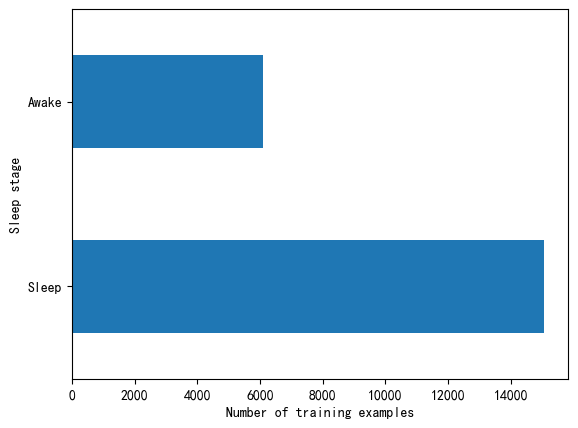

In [27]:
classes_mapping = {1: "Awake", 0: "Sleep"} #This mapping is based on the output of 'extract_epochs'
y_train = pd.Series([y for _, y in train_ds]).map(classes_mapping)
ax = y_train.value_counts().plot(kind='barh')
ax.set_xlabel('Number of training examples');
ax.set_ylabel('Sleep stage')
pylab.show();

In [28]:
 y_train.value_counts()

Sleep    15080
Awake     6086
Name: count, dtype: int64

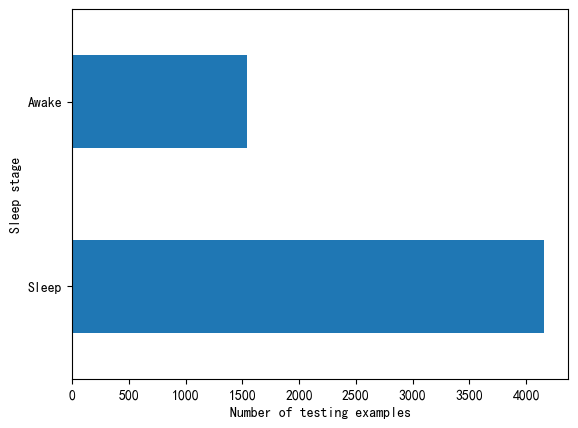

In [29]:
classes_mapping = {1: "Awake", 0: "Sleep"} #This mapping is based on the output of 'extract_epochs'
y_train_test = pd.Series([y for _, y in test_ds]).map(classes_mapping)
ax = y_train_test.value_counts().plot(kind='barh')
ax.set_xlabel('Number of testing examples');
ax.set_ylabel('Sleep stage')
pylab.show();

In [30]:
 y_train_test.value_counts()

Sleep    4161
Awake    1540
Name: count, dtype: int64

There is a class imbalance. <br>
During training, we'd like to give more weight to examples from rarer classes when computing the loss.

In [31]:
# Computing class weight
from sklearn.utils.class_weight import compute_class_weight

train_y = np.concatenate([ds.epochs_labels for ds in train_ds.datasets])
class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
print(class_weights)

[0.70179045 1.73890897]


## 3. Modeling

### 3.1 CNN model

In [32]:
from torch import nn


class SleepStagerChambon2018(nn.Module):
    """Sleep staging architecture from [1]_.
    
    Convolutional neural network for sleep staging described in [1]_.
    
    Parameters
    ----------
    n_channels : int
        Number of EEG channels.
    sfreq : float
        EEG sampling frequency.
    n_conv_chs : int
        Number of convolutional channels. Set to 8 in [1]_.
    time_conv_size_s : float
        Size of filters in temporal convolution layers, in seconds. Set to 0.5
        in [1]_ (64 samples at sfreq=128).
    max_pool_size_s : float
        Max pooling size, in seconds. Set to 0.125 in [1]_ (16 samples at
        sfreq=128).
    n_classes : int
        Number of classes.
    input_size_s : float
        Size of the input, in seconds.
    dropout : float
        Dropout rate before the output dense layer.
        
    References
    ----------
    .. [1] Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., &
           Gramfort, A. (2018). A deep learning architecture for temporal sleep
           stage classification using multivariate and multimodal time series.
           IEEE Transactions on Neural Systems and Rehabilitation Engineering,
           26(4), 758-769.
    """
    def __init__(self, n_channels, sfreq, n_conv_chs=8, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, n_classes=2, input_size_s=30,
                 dropout=0.25):
        super().__init__()

        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = int(max_pool_size_s * sfreq)
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        len_last_layer = self._len_last_layer(
            n_channels, input_size, max_pool_size, n_conv_chs)

        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(
                n_conv_chs, n_conv_chs, (1, time_conv_size),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(len_last_layer, n_classes)
        )

    @staticmethod
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, x):
        """Forward pass.
        
        Parameters
        ---------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)

        x = self.feature_extractor(x)
        return self.fc(x.flatten(start_dim=1))

### 3.2 Load the data and model.

In [33]:
raws = raws_analysis_1

In [34]:
sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']  # Number of channels

model = SleepStagerChambon2018(n_channels, sfreq, n_classes=2)

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device \'{device}\'.')
model = model.to(device)

Using device 'cuda'.


In [36]:
from torch.utils.data import DataLoader

# Create dataloaders
train_batch_size = 128  # Important hyperparameter
valid_batch_size = 256  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

loader_train = DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
loader_valid = DataLoader(
    valid_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(
    test_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)

In [37]:
len(loader_train)
len(loader_valid)
len(loader_test)

23

In [38]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, roc_auc_score

def _do_train(model, loader, optimizer, criterion, device, metric):
    # training loop
    model.train()
    
    train_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    for idx_batch, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.int64)

        output = model(batch_x)
        loss = criterion(output, batch_y)

        loss.backward()
        optimizer.step()
        
        y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
        y_true_all.append(batch_y.cpu().numpy())

        train_loss[idx_batch] = loss.item()
        
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)
    
    return np.mean(train_loss), perf
        

def _validate(model, loader, criterion, device, metric):
    # validation loop
    model.eval()
    
    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    with torch.no_grad():
        for idx_batch, (batch_x, batch_y) in enumerate(loader):
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y = batch_y.to(device=device, dtype=torch.int64)
            output = model.forward(batch_x)

            loss = criterion(output, batch_y)
            val_loss[idx_batch] = loss.item()
            
            y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())
            
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(val_loss), perf


def train(model, loader_train, loader_valid, optimizer, criterion, n_epochs, 
          patience, device, metric=None):
    """Training function.
    
    Parameters
    ----------
    model : instance of nn.Module
        The model.
    loader_train : instance of Sampler
        The generator of EEG samples the model has to train on.
        It contains n_train samples
    loader_valid : instance of Sampler
        The generator of EEG samples the model has to validate on.
        It contains n_val samples. The validation samples are used to
        monitor the training process and to perform early stopping
    optimizer : instance of optimizer
        The optimizer to use for training.
    n_epochs : int
        The maximum of epochs to run.
    patience : int
        The patience parameter, i.e. how long to wait for the
        validation error to go down.
    metric : None | callable
        Metric to use to evaluate performance on the training and
        validation sets. Defaults to balanced accuracy.
        
    Returns
    -------
    best_model : instance of nn.Module
        The model that led to the best prediction on the validation
        dataset.
    history : list of dicts
        Training history (loss, accuracy, etc.)
    """
    best_valid_loss = np.inf
    best_model = copy.deepcopy(model)
    waiting = 0
    history = list()
    
    if metric is None:
        metric = balanced_accuracy_score
        
    print('epoch \t train_loss \t valid_loss \t train_perf \t valid_perf')
    print('-------------------------------------------------------------------')

    for epoch in range(1, n_epochs + 1):
        train_loss, train_perf = _do_train(
            model, loader_train, optimizer, criterion, device, metric=metric)
        valid_loss, valid_perf = _validate(
            model, loader_valid, criterion, device, metric=metric)
        history.append(
            {'epoch': epoch, 
             'train_loss': train_loss, 'valid_loss': valid_loss,
             'train_perf': train_perf, 'valid_perf': valid_perf})
        
        print(f'{epoch} \t {train_loss:0.4f} \t {valid_loss:0.4f} '
              f'\t {train_perf:0.4f} \t {valid_perf:0.4f}')

        # model saving
        if valid_loss < best_valid_loss:
            print(f'best val loss {best_valid_loss:.4f} -> {valid_loss:.4f}')
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            waiting = 0
        else:
            waiting += 1

        # model early stopping
        if waiting >= patience:
            print(f'Stop training at epoch {epoch}')
            print(f'Best val loss : {best_valid_loss:.4f}')
            break

    return best_model, history

In [39]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0)
criterion = CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device)) #compute loss based on class_weights

In [40]:
torch.Tensor(class_weights).to(device)

tensor([0.7018, 1.7389], device='cuda:0')

In [41]:
n_epochs = 30
patience = 10

best_model, history = train(
    model, loader_train, loader_valid, optimizer, criterion, n_epochs, patience, 
    device, metric=cohen_kappa_score)

epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf
-------------------------------------------------------------------
1 	 0.6030 	 0.5543 	 0.2987 	 0.4589
best val loss inf -> 0.5543
2 	 0.4994 	 0.4988 	 0.4902 	 0.5437
best val loss 0.5543 -> 0.4988
3 	 0.4583 	 0.4690 	 0.5492 	 0.5829
best val loss 0.4988 -> 0.4690
4 	 0.4315 	 0.4244 	 0.5850 	 0.6058
best val loss 0.4690 -> 0.4244
5 	 0.4099 	 0.5172 	 0.6107 	 0.4955
6 	 0.4039 	 0.4451 	 0.6151 	 0.5690
7 	 0.3952 	 0.4183 	 0.6308 	 0.6121
best val loss 0.4244 -> 0.4183
8 	 0.3855 	 0.4356 	 0.6334 	 0.5793
9 	 0.3786 	 0.4319 	 0.6377 	 0.5712
10 	 0.3858 	 0.4364 	 0.6287 	 0.5869
11 	 0.3768 	 0.4611 	 0.6438 	 0.5483
12 	 0.3732 	 0.4353 	 0.6474 	 0.5958
13 	 0.3682 	 0.4509 	 0.6425 	 0.5702
14 	 0.3605 	 0.4401 	 0.6530 	 0.5771
15 	 0.3616 	 0.4885 	 0.6520 	 0.5558
16 	 0.3695 	 0.4326 	 0.6409 	 0.6011
17 	 0.3586 	 0.4656 	 0.6546 	 0.5748
Stop training at epoch 17
Best val loss : 0.4183


### 3.3 save the model and load

#### Save and load the best model.

In [42]:
model_path = './saved model/2classes_epochs30_v2.pt'
torch.save(best_model, model_path)
loaded_model = torch.load(model_path)
loaded_model.cuda()

SleepStagerChambon2018(
  (spatial_conv): Conv2d(1, 12, kernel_size=(12, 1), stride=(1, 1))
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 250), stride=(1, 1), padding=(0, 125))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 62), stride=(1, 62), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 8, kernel_size=(1, 250), stride=(1, 1), padding=(0, 125))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(1, 62), stride=(1, 62), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=288, out_features=2, bias=True)
  )
)

#### Save and load the history.

In [43]:
import pickle
#Save the history
history_path = './saved model/2classes_epochs30_v2.txt'
with open(history_path, "wb") as fp:
    pickle.dump(history, fp)

In [44]:
#load the history
with open(history_path, 'rb') as fp:
    loaded_history = pickle.load(fp)

## 4. evaluation

### 4.1 Visualize the training process.

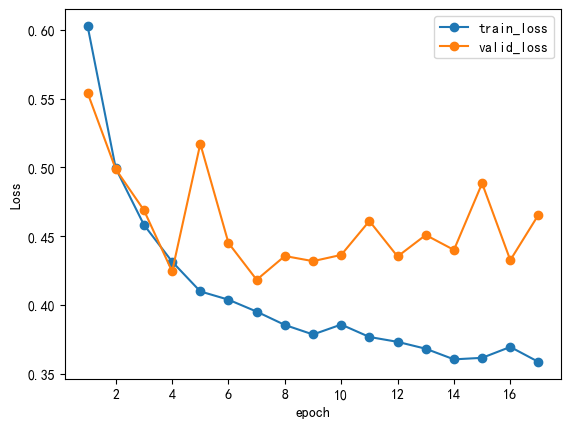

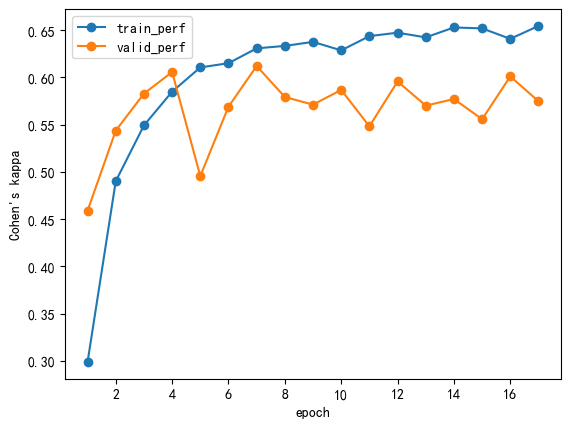

In [45]:
# Visualizing the learning curves epochs=10

history_df = pd.DataFrame(loaded_history)
ax1 = history_df.plot(x='epoch', y=['train_loss', 'valid_loss'], marker='o')
ax1.set_ylabel('Loss')
ax2 = history_df.plot(x='epoch', y=['train_perf', 'valid_perf'], marker='o')
ax2.set_ylabel('Cohen\'s kappa')
pylab.show();

### 4.2 Metrics

- best model: loaded_model
- y_pred
- y_true
- rec_ids_test

#### Test

In [46]:
# Compute test performance
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, roc_auc_score, f1_score, recall_score, precision_score, fbeta_score,classification_report
from sklearn.metrics import accuracy_score

loaded_model.eval()

y_pred_all, y_true_all = list(), list()
for batch_x, batch_y in loader_test:
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    output = loaded_model.forward(batch_x)
    y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
    y_true_all.append(batch_y.cpu().numpy())
    
y_pred = np.concatenate(y_pred_all)
y_true = np.concatenate(y_true_all)
rec_ids_test = np.concatenate(  # indicates which recording each example comes from
    [[i] * len(ds) for i, ds in enumerate(test_ds.datasets)])

#Compute the balanced accuracy and kappa
test_bal_acc = balanced_accuracy_score(y_true, y_pred)
test_kappa = cohen_kappa_score(y_true, y_pred)
test_acc = accuracy_score(y_true, y_pred)


labels = [0,1]
target_names = ['Sleep', 'Awake'] 
c_3test = classification_report(y_true, y_pred, labels=labels, target_names = target_names, output_dict = True)


print(f'Test balanced accuracy: {test_bal_acc:.1%}')
print(f'Test accuracy: {test_acc:.1%}')
print(f'Test Cohen\'s kappa: {test_kappa:.1%}')

Test balanced accuracy: 75.6%
Test accuracy: 84.3%
Test Cohen's kappa: 56.2%


#### Train

In [51]:
# Compute training data performance

y_pred_train, y_true_train = list(), list()
for batch_x, batch_y in loader_train:
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    output = best_model.forward(batch_x)
    y_pred_train.append(torch.argmax(output, axis=1).cpu().numpy())
    y_true_train.append(batch_y.cpu().numpy())
    
y_pred_train_all = np.concatenate(y_pred_train)
y_true_train_all = np.concatenate(y_true_train)
rec_ids_train = np.concatenate(  # indicates which recording each example comes from
    [[i] * len(ds) for i, ds in enumerate(train_ds.datasets)])

train_bal_acc = balanced_accuracy_score(y_true_train_all, y_pred_train_all)
train_kappa = cohen_kappa_score(y_true_train_all, y_pred_train_all)


labels = [0,1]
target_names = ['Sleep', 'Awake'] 
c_3train = classification_report(y_true_train_all, y_pred_train_all, labels=labels, target_names = target_names, output_dict = True)


print(f'Train balanced accuracy: {train_bal_acc:.1%}')
print(f'Train Cohen\'s kappa: {train_kappa:.1%}')

Train balanced accuracy: 84.2%
Train Cohen's kappa: 64.7%


#### Valid

In [52]:
# Compute validation dataset performance

y_pred_valid, y_true_valid = list(), list()
for batch_x, batch_y in loader_valid:
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    output = best_model.forward(batch_x)
    y_pred_valid.append(torch.argmax(output, axis=1).cpu().numpy())
    y_true_valid.append(batch_y.cpu().numpy())
    
y_pred_valid_all = np.concatenate(y_pred_valid)
y_true_valid_all = np.concatenate(y_true_valid)
rec_ids_valid = np.concatenate(  # indicates which recording each example comes from
    [[i] * len(ds) for i, ds in enumerate(valid_ds.datasets)])

valid_bal_acc = balanced_accuracy_score(y_true_valid_all, y_pred_valid_all)
valid_kappa = cohen_kappa_score(y_true_valid_all, y_pred_valid_all)


labels = [0,1]
target_names = ['Sleep', 'Awake'] 
c_3valid = classification_report(y_true_valid_all, y_pred_valid_all, labels=labels, target_names = target_names, output_dict = True)


print(f'Valid balanced accuracy: {valid_bal_acc:.1%}')
print(f'Valid Cohen\'s kappa: {valid_kappa:.1%}')

Valid balanced accuracy: 80.9%
Valid Cohen's kappa: 61.2%


### Per subject performance

In [49]:
df_test = pd.DataFrame({'true': y_true, 'prediction': y_pred})
# df_train = pd.DataFrame({'true': y_pred_train_all, 'prediction': y_true_train_all})
# df_valid = pd.DataFrame({'true': y_pred_valid_all, 'prediction': y_true_valid_all})

df_test['subj_index'] = rec_ids_test

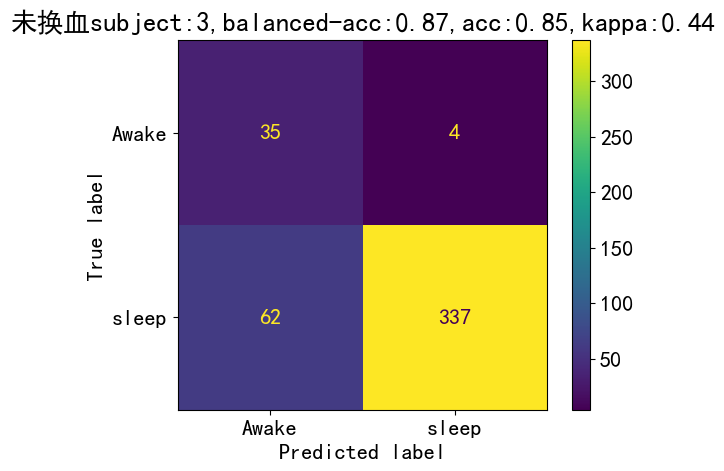

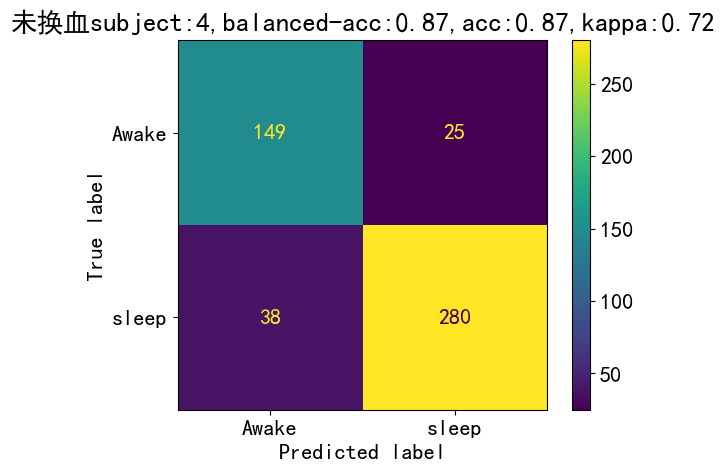

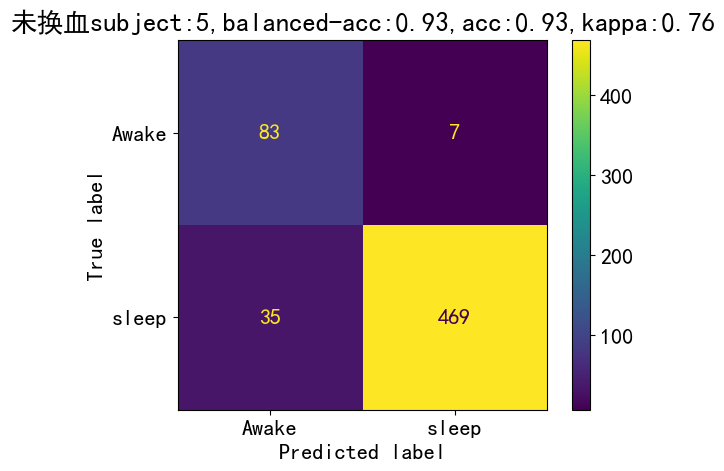

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


classes_mapping = {1: "Awake", 0: "sleep"}
display_labels = list(classes_mapping.values())


labels = [1,0]

# for i in (0,1,2):
for i in (3,4,5):
    y_true = df_test[df_test["subj_index"] ==i].true
    y_pred = df_test[df_test["subj_index"] ==i].prediction

    #calculate metrics
    balanced_accuracy_subject = round(balanced_accuracy_score(y_true, y_pred),2)
    accuracy_subject = round(accuracy_score(y_true, y_pred), 2)
    kappa_subject = round(cohen_kappa_score(y_true, y_pred),2)
    #confusion matrix
    conf_matrix_subject = confusion_matrix(y_true, y_pred, labels = labels)
    disp_subject = ConfusionMatrixDisplay(confusion_matrix = conf_matrix_subject, display_labels = display_labels)
    

    
    disp_subject.plot()
    plt.rcParams.update({'font.size': 16})
    plt.title('未换血subject:{s},balanced-acc:{b},acc:{a},kappa:{k}'.format(s=i,a=accuracy_subject,b=balanced_accuracy_subject,k=kappa_subject))
    
    plt.show()


In [55]:
ch_names = raws[1].ch_names
n_chan = len(ch_names)  # note: there is no raw.n_channels attribute

# Evaluation_matrics_all = Evaluation_matrics_all.style.set_caption('3-classes performance evaluation')
metric_3classes = pd.DataFrame({"Num of Channels": [n_chan],
                                      "Channel names": [list(ch_names)],
                                       "classes": ['Awake/Sleep'],
                                       "Test balanced accuracy": [test_bal_acc],
                                       "Train balanced accuracy": [train_bal_acc],
                                       "Validation balanced accuracy": [valid_bal_acc],
                                       "Test Cohen\'s kappa": [test_kappa],
                                       "Train Cohen\'s kappa": [train_kappa],
                                       "Validation Cohen\'s kappa": [valid_kappa]
                                       
                                      
                                      
                                      })

metric_3classes.style.format({'Test balanced accuracy': "{:.1%}", 'Train balanced accuracy': "{:.1%}", 'Validation balanced accuracy': "{:.1%}", 'Test Cohen\'s kappa': "{:.1%}", 'Train Cohen\'s kappa': "{:.1%}", 'Validation Cohen\'s kappa': "{:.1%}"})





,Num of Channels,Channel names,classes,Test balanced accuracy,Train balanced accuracy,Validation balanced accuracy,Test Cohen's kappa,Train Cohen's kappa,Validation Cohen's kappa
0,12,"['Fp1-AV', 'Fp2-AV', 'C3-AV', 'C4-AV', 'P3-AV', 'P4-AV', 'O1-AV', 'O2-AV', 'T3-AV', 'T4-AV', 'Cz-AV', 'Pz-AV']",Awake/Sleep,75.6%,84.2%,80.9%,56.2%,64.7%,61.2%
